# [Food Recognition Based on Pre-trained CNN Model]
In this notebook, we will give a step-by-step guidance on how to apply pre-trained CNN model on food recognition task.

Before running any code, we do the following two steps:
1. Reset the runtime by going to **Runtime -> Reset all runtimes** in the menu above. 
2. Select GPU by going to **Runtime -> Change runtime type -> Hardware accelerator** in the menu above. 



### Transfer Learning
In this tutorial, we will show an example of using pre-trained CNN model on food recognition task.
There are many exsiting trained model, which are desined by AI experts and trained on a large dataset of images.
Considering the similarity between different computer vision tasks, these models can be easily extended to other computer vision tasks.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.



## [Importing packages]

First, we will import some packages which will be used in our codes. 

- `os` : for read files 
- `numpy`: for matrix computation 
- `matplotlib.pyplot`: for graph plotting and display
- `tensorflow`: the main deep learning toolbox
- `tf.keras.preprocessing.image.ImageDataGenerator`: for load data


## [Dataset Description]
- Food-11   
This is a dataset containing 16643 food images grouped in 11 major food categories. The 11 categories are Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit. The whole dataset is divided in three parts: training, validation and evaluation. The same naming convention is used, where ID 0-10 refers to the 11 food categories respectively.   
More info can be seen from [Food/Non-food Image Classification and Food Categorization using Pre-Trained GoogLeNet Model](https://infoscience.epfl.ch/record/221610/files/madima2016_food_recognition.pdf)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>Bread</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Dairy product</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Dessert</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Egg</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Fried food</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Meat</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Noodles/Pasta</td> 
  </tr>
    <tr>
    <td>7</td>
    <td> Rice</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Seafood</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Soup</td> 
  </tr>
       <tr>
    <td>10</td>
    <td>Vegetable/Fruit</td> 
  </tr>
</table>


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

In [0]:
class_names = ['Bread','Dairy product','Dessert','Egg','Fried food',
               'Meat','Noodles/Pasta','Rice','Seafood','Soup','Vegetable/Fruit']

In [0]:
if not os.path.exists('/root/.keras/datasets/'):
    os.makedirs('/root/.keras/datasets/')

In [0]:
%cd /root/.keras/datasets/
!wget https://www.dropbox.com/s/npdntunlaxioaw9/Food-11.zip
!unzip -uq Food-11.zip

/root/.keras/datasets
--2019-05-14 02:24:34--  https://www.dropbox.com/s/npdntunlaxioaw9/Food-11.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/npdntunlaxioaw9/Food-11.zip [following]
--2019-05-14 02:24:34--  https://www.dropbox.com/s/raw/npdntunlaxioaw9/Food-11.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc89035e857cf0f9c0ace661db43.dl.dropboxusercontent.com/cd/0/inline/Ag3VF6_MrHeMNI3qIipY7oY0H7DNXstfahqCjoXVdlXhcjZ-r-I_L-N90SInQOeDySHYskgH1KsYmFemT18mlBpnT1uR_JCOA6eId7POnB4tTA/file# [following]
--2019-05-14 02:24:34--  https://uc89035e857cf0f9c0ace661db43.dl.dropboxusercontent.com/cd/0/inline/Ag3VF6_MrHeMNI3qIipY7oY0H7DNXstfahqCjoXVdlXhcjZ-r-I_L-N90SInQOeDySHYskgH1KsYmFemT18mlBpnT1uR_JCOA6eId7POnB4tTA/fi

In [0]:
!ls /root/.keras/datasets/

Food-11  Food-11.zip  Food-11.zip.1  ImageNetLabels.txt  vgg15_ft1layer.hd5


We'll now assign variables with the proper file path for the training and validation sets.

In [0]:
base_dir = '/root/.keras/datasets/Food-11'
train_dir = os.path.join(base_dir, 'training/')
validation_dir = os.path.join(base_dir, 'validation/')

test_dir = os.path.join(base_dir, 'evaluation/')

In [0]:
total_train = 0
for dirpath, dirnames,filenames in os.walk(train_dir):
  for file in filenames:
    total_train = total_train+1
    
total_val = 0
for dirpath, dirnames,filenames in os.walk(validation_dir):
  for file in filenames:
    total_val = total_val+1
    
total_test = 0
for dirpath, dirnames,filenames in os.walk(test_dir):
  for file in filenames:
    total_test = total_test+1

In [0]:
print("Total training images:", total_train)
print("Total validation images:", total_val)

print("Total test images: ", total_test)

Total training images: 9866
Total validation images: 3430
Total test images:  3347


### Define several model parameters
Here, we will set up variables that will be used later while pre-processing our dataset and training our network.

In [0]:
BATCH_SIZE = 8
IMG_SHAPE = 224

### Data preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. We use `tf.keras.preprocessing.image.ImageDataGenerator` to do data preparation.
 
- Read images from the disk
- Convert them into floating point tensors for usage in networks

In this work, we use the pretrained VGG16 model. Thus, we need to preprocess our images just as the same to VGG16 input. The *preprocess_input* function coming with vgg16 can help achieve this.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.preprocessing import image

from keras.layers import Dense

from keras.models import Model
from keras.models import load_model

from keras import backend as K

In [0]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  

flow_from_directory method can load images from the disk, and apply rescaling, and resize on images.

In [0]:
train_datagen = datagen.flow_from_directory(directory=train_dir, 
                                                           shuffle=True, 
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(224,224) 
                                                           batch_size=BATCH_SIZE, 
                                                           class_mode='categorical')
val_datagen = datagen.flow_from_directory(directory=validation_dir, 
                                                           shuffle=False, 
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(224,224) 
                                                           batch_size=BATCH_SIZE, 
                                                           class_mode='categorical')

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


Here, we show some image samples from the dataset.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
W0514 02:25:09.128654 140414654158720 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0514 02:25:09.145025 140414654158720 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0514 02:25:09.160070 140414654158720 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0514 02:25:09.173806 140414654158720 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0514 02:25:09.187629 140414654158720 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0

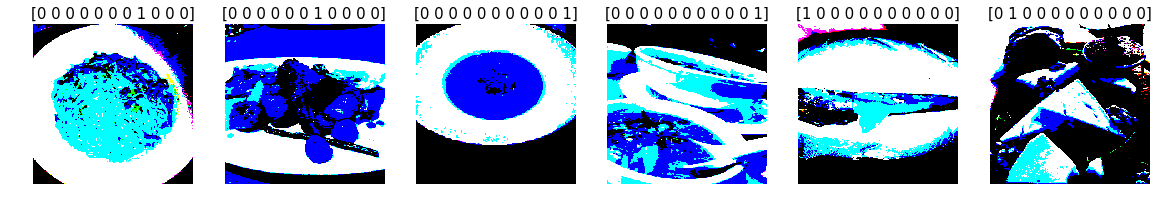

In [0]:
# plots images with labels 
def plotImg(ims, figsize=(20,20),titles=None):  
    f = plt.figure(figsize=figsize)
    for i in range(6):
        sp = f.add_subplot(1, 6, i+1)
        sp.axis('Off')
        if titles is not None:          
          sp.set_title(titles[i], fontsize=15)
        plt.imshow(ims[i])
        
imgs, labels = next(train_datagen)
plotImg(imgs, titles=labels.astype(int))


## [Construct the Model]


In this tutorial, we will use the pretrained VGG-16 model, load it into keras, and use it on our dataset.

### Use VGG16 Net for direct prediction 
Download VGG16 model from Tensorflow Hub, and create a Keras model from it. VGG16 is designed for processing images of $224\times224\times3$ size. (image hegiht$\times$image width$\times$color channel)

In [0]:
vggnet = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet',
                                           input_tensor=None, input_shape=None,
                                          pooling = None, classes=1000)

In [0]:
import random

egpath = os.path.join(train_dir,'1/')

image_path = random.choice([x for x in os.listdir(egpath)
               if os.path.isfile(os.path.join(egpath, x))])


img = image.load_img(os.path.join(egpath,image_path), target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

result = vggnet.predict(x)
predicted_class = np.argmax(result[0], axis=-1)
print(predicted_class)

969


To see what image class the prediction represents, we download the ImageNet labels and get the class_name by its integer value.

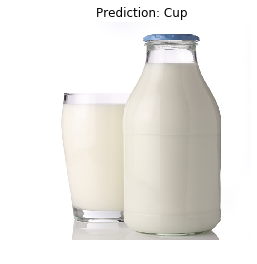

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())


plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

### Fine-tune VGG16 on our new dataset


VGG16 model, with weights pre-trained on ImageNet.   
include_top: whether to include the 3 fully-connected layers at the top of the network.

VGG16 has 13 conv layers and 3 fully-connected layers. 


In [0]:
base_model = VGG16(weights='imagenet', include_top = True)
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We remove the final dense layer, which is to predict the probabilities of 1000 classes.
And add one dense layer with 11 nodes, which corresponds to our 11 classes.

In [0]:
base_model.layers.pop()
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
x = base_model.output
# Let's add a fully-connected layer with 11 units
predictions = Dense(11, activation='softmax')(x)

# This would be the new model we will train
model = Model(inputs=base_model.input, outputs = predictions)

So far, we have modified the VGG16 model to output 11 class probability, for our task.   
We add a new layer with random initialized weights. We want to train our new model to get a good performance.
The training procedure is as follows:
1. We freeze the model parameters, and only train the new added layer.
2. After the new added layer has a proper parameters, we can un-freeze some previous layers and retrain the model, to see whether further fine-tuning can improve the performance.


In [0]:
# Freeze all the layers coming with VGG16
for layer in base_model.layers:
    layer.trainable = False   

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
             metrics=['accuracy'])

## [Training model]


In [0]:
EPOCHS = 10

history = model.fit_generator(
    train_datagen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_datagen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Use tf.cast instead.


W0514 02:25:14.691697 140414654158720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/5
987/987 [==============================] - 123s 125ms/step - loss: 2.0131 - acc: 0.5393 - val_loss: 1.7290 - val_acc: 0.6265
Epoch 2/5
987/987 [==============================] - 114s 115ms/step - loss: 1.5128 - acc: 0.6618 - val_loss: 1.3798 - val_acc: 0.6708
Epoch 3/5
987/987 [==============================] - 112s 113ms/step - loss: 1.2113 - acc: 0.7097 - val_loss: 1.1809 - val_acc: 0.6866
Epoch 4/5
987/987 [==============================] - 112s 113ms/step - loss: 1.0376 - acc: 0.7253 - val_loss: 1.0436 - val_acc: 0.7079
Epoch 5/5
987/987 [==============================] - 115s 116ms/step - loss: 0.9355 - acc: 0.7385 - val_loss: 1.0066 - val_acc: 0.7067


### Save the model file to your Google Drive

Then you can always access your model file for future usage.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
nbpath = r'/content/gdrive/My Drive/AIcourseJune/notebooks'
model.save(os.path.join(nbpath,'vgg15_ft1layer.hd5'))

### CASE 1: Data augmentation
We use **data augmentation** to improve the model performance.   
Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques to examples from the training data that create new and different training examples.   
We would like to explore:
- Flipping the image horizontally
- Rotating the image
- Applying Zoom


In [0]:
aug_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,  
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest') 

train_datagen = aug_datagen.flow_from_directory(directory=train_dir,                                                                                      
                                            shuffle=True, 
                                            target_size=(IMG_SHAPE,IMG_SHAPE), #(224,224) 
                                            batch_size=BATCH_SIZE, 
                                            class_mode='categorical')

Found 9866 images belonging to 11 classes.


We recompile the model for these modifications to take effect. 

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [0]:
EPOCHS = 50

history = model.fit_generator(
    train_datagen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_datagen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/50
987/987 [==============================] - 194s 196ms/step - loss: 1.0706 - acc: 0.6842 - val_loss: 1.0016 - val_acc: 0.7006
Epoch 2/50
745/987 [=====================>........] - ETA: 39s - loss: 1.0229 - acc: 0.6964

### CASE 2: Fine-tune more layers
We choose to fune-tune the top 2 fully-connected layers. That is, we will freeze the first layers and unfreeze the rest:



After the top layer are well trained, we can start fine-tuning other layers by unfreeze them.
We can visualize the layers names and indices to see how many layers we would like to freeze.

In [0]:
for i, layer in enumerate(base_model.layers):
  print(i,layer.name)

In [0]:
for layers in model.layers[:19]:
  layer.trainable = False
for layers in model.layers[19:]:
  layer.trainable = True

We train our model again (this time fine-tuning the top 2 fully-connected layers, and the top Dense layer we add before).   
We recompile the model for these modifications to take effect. 

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
             metrics=['accuracy'])

In [0]:
EPOCHS = 100

history = model.fit_generator(
    train_datagen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_datagen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

### CASE 3: Change the optimizer


This time, we use SGD with a low learning rate.

In [0]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
EPOCHS = 100

history = model.fit_generator(
    train_datagen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_datagen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

### Visualize the training process   
Here, we visualize the training process to have a better understanding of our model.
To see the performance of our model, and get some insights on how to tune our model for better performance.

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

## [Evaluating Model]
It is always a good practice to evaludate our models on held out samples.
We use the training data to learn the neural networks parameters, such as the weights and bias.
We use the validation data to verify whether our model is overfitting on the training data, to balance our model to get good performance on both training and validation data.
And finally, the test data is totally un-used in our development of our model. And its performance is generally fair enough to compare different models.



In [0]:
test_datagen = datagen.flow_from_directory(directory=test_dir, 
                                                           shuffle=False, 
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(224,224) 
                                                           batch_size=BATCH_SIZE, 
                                                           class_mode='categorical')

score = model.evaluate_generator(generator=test_datagen,
                                 steps = int(np.ceil(total_test / float(BATCH_SIZE))))
print("Test Loss: ", score[0], "Test Accuracy: ", score[1])

## [Save and Load Model]

In [0]:
from keras.models import load_model

model.save('my_model.h5') 

# del model    # deletes the existing model

# model = tf.keras.models.load_model('my_model.h5')